In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Process Datasets

Static features dataset from Matthias, death time series from CSSE, Hospital Data

In [2]:
deaths_t_series = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
deaths_t_series = deaths_t_series.loc[~(deaths_t_series['Lat'] == 0)]
deaths_t_series = deaths_t_series.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', "Combined_Key", "Population"], axis=1)

In [35]:
hospitals = pd.read_csv('../Hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS']]
static_features = pd.read_csv('../COVID-19_US_County-level_Summaries/data/counties_only.csv')[['FIPS', 'Rural-urban_Continuum Code_2013', 'Area in square miles - Total area', 'Percent of adults with less than a high school diploma 2014-18', 'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus', 'POP_ESTIMATE_2018']]
static_features = static_features.dropna()
static_features['area'] = static_features['Area in square miles - Total area']
static_features['no_dip'] = static_features['Percent of adults with less than a high school diploma 2014-18']
static_features['elderly_ratio'] = static_features['Total_age65plus']/static_features['POP_ESTIMATE_2018']
static_features['RUCC'] = static_features['Rural-urban_Continuum Code_2013']

In [36]:
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)
fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   
    if len(grp) > 100:
        print(fips_code)
hosp_data.head()

6037


,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


In [31]:
adjacent_counties = pd.read_excel('../adjacent_counties.xlsx', header=None)
adjacent_counties = adjacent_counties[[1, 3]]
adjacent_counties = adjacent_counties[adjacent_counties[1] != adjacent_counties[3]]
pairs = []
for index, row in adjacent_counties.iterrows():
    pair = set([row[1], row[3]])
    if pair not in pairs:
        pairs.append(pair)
np.random.seed(9)
np.random.shuffle(pairs)

In [6]:
print(len(pairs))

9483


In [7]:
dl_index = pd.read_csv('../DL-us-m50_index.csv')
dl_abs_movement = pd.read_csv('../DL-us-m50.csv')
dl_index = dl_index.dropna()
dl_abs_movement = dl_abs_movement.dropna()
dl = dl_index.merge(dl_abs_movement, on='fips')

baseline1 = pd.DataFrame(dl['2020-03-01_y'] / (.01 * dl['2020-03-01_x']))
baseline2 = pd.DataFrame(dl['2020-03-02_y'] / (.01 * dl['2020-03-02_x']))
baseline3 = pd.DataFrame(dl['2020-03-03_y'] / (.01 * dl['2020-03-03_x']))
baselines = pd.concat((baseline1, baseline2, baseline3), axis=1)

pd.set_option('display.max_rows', None)
dl['baseline'] = baselines.mean(axis=1)
baseline_data = dl[['baseline', 'fips']]
baseline_data['FIPS'] = baseline_data['fips']
baseline_data = baseline_data.drop(['fips'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Define helper function for testing features

In [8]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression as logreg

def test_features(features):
    train_x = training_set[features].to_numpy()
    train_y = training_set['More_Deaths'].to_numpy()
    test_x = test_set[features].to_numpy()
    test_y = test_set['More_Deaths'].to_numpy()

    train_x, train_y = shuffle(train_x, train_y, random_state=0)
    test_x, test_y = shuffle(test_x, test_y, random_state=0)
    train_y = np.ravel(train_y)
    test_y = np.ravel(test_y)
    
    print(f'Features: {features}')
    print(f'Test Ratio: {sum(test_y)/len(test_y)}')

    lr = logreg().fit(train_x, train_y)
    print(f'Score: {lr.score(test_x, test_y)}')
    print(f'Coefficients: {lr.coef_}\n')

# 3 Death Thresh, 20 Days Out

In [9]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 20

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh:

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break 

In [10]:
death_data['Deaths'].max()

4399.0

Merge Datasets

In [11]:
dataset = hosp_data.merge(death_data, on='FIPS')
dataset = dataset.merge(baseline_data, on='FIPS')
dataset = dataset.merge(static_features, on="FIPS")
dataset = dataset.sample(frac=1.0, random_state=9)[['FIPS', 'HospCt', 'Beds', 'Deaths', 'RUCC', 'area', 'no_dip', 'elderly_ratio', 'Unemployment_rate_2018', 'PCTPOV017_2018', 'POP_ESTIMATE_2018', 'baseline']]
dataset.head()

,FIPS,HospCt,Beds,Deaths,RUCC,area,no_dip,elderly_ratio,Unemployment_rate_2018,PCTPOV017_2018,POP_ESTIMATE_2018,baseline
454,34029,4,1270,201.0,1,915.40,8.2,0.225466,4.3,16.1,601651,9.046544
260,21015,1,161,11.0,1,256.46,7.2,0.135358,3.4,8.7,131533,10.643580
649,45091,1,288,3.0,1,695.81,10.4,0.143135,3.3,13.0,274118,10.664462
143,13057,1,79,10.0,1,434.41,8.6,0.139210,3.1,9.4,254149,10.695116
654,47065,8,1577,12.0,2,575.88,10.8,0.175768,3.4,18.1,364286,9.952645


array([[1.       , 0.9598644],
       [0.9598644, 1.       ]])

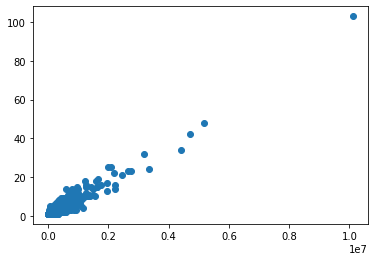

In [12]:
plt.scatter(dataset['POP_ESTIMATE_2018'].astype(float), dataset['HospCt'].astype(float))
np.corrcoef(dataset['POP_ESTIMATE_2018'].astype(float), dataset['HospCt'].astype(float))

array([[1.        , 0.93297445],
       [0.93297445, 1.        ]])

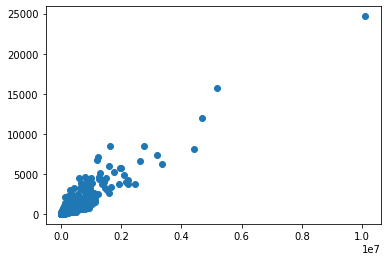

In [13]:
plt.scatter(dataset['POP_ESTIMATE_2018'].astype(float), dataset['Beds'].astype(float))
np.corrcoef(dataset['POP_ESTIMATE_2018'].astype(float), dataset['Beds'].astype(float))

array([[1.        , 0.95104851],
       [0.95104851, 1.        ]])

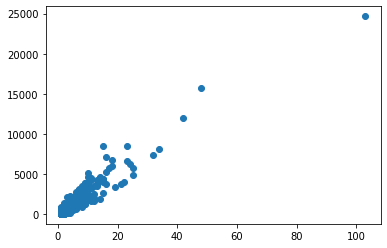

In [14]:
plt.scatter(dataset['HospCt'].astype(float), dataset['Beds'].astype(float))
np.corrcoef(dataset['HospCt'].astype(float), dataset['Beds'].astype(float))

## Normalize Variables By Population

In [15]:
dataset['Deaths'] = dataset['Deaths']/dataset['POP_ESTIMATE_2018']
dataset['Beds'] = dataset['Beds']/dataset['POP_ESTIMATE_2018']
dataset['HospCt'] = dataset['HospCt']/dataset['POP_ESTIMATE_2018']
dataset.head()

,FIPS,HospCt,Beds,Deaths,RUCC,area,no_dip,elderly_ratio,Unemployment_rate_2018,PCTPOV017_2018,POP_ESTIMATE_2018,baseline
454,34029,6.64837e-06,0.00211086,0.000334,1,915.40,8.2,0.225466,4.3,16.1,601651,9.046544
260,21015,7.60265e-06,0.00122403,0.000084,1,256.46,7.2,0.135358,3.4,8.7,131533,10.643580
649,45091,3.64806e-06,0.00105064,0.000011,1,695.81,10.4,0.143135,3.3,13.0,274118,10.664462
143,13057,3.9347e-06,0.000310841,0.000039,1,434.41,8.6,0.139210,3.1,9.4,254149,10.695116
654,47065,2.19608e-05,0.00432902,0.000033,2,575.88,10.8,0.175768,3.4,18.1,364286,9.952645


array([[1.        , 0.32643499],
       [0.32643499, 1.        ]])

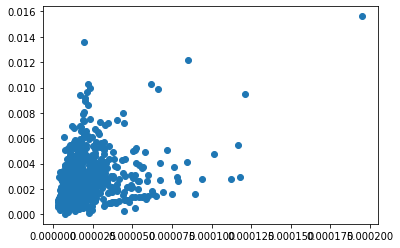

In [16]:
plt.scatter(dataset['HospCt'].astype(float), dataset['Beds'].astype(float))
np.corrcoef(dataset['HospCt'].astype(float), dataset['Beds'].astype(float))

Exclude some outliers

480    36061
720    51131
Name: FIPS, dtype: object
299    22081
2       1013
251    20031
628    45005
727    51595
416    28133
Name: FIPS, dtype: object


array([[1.        , 0.45379876],
       [0.45379876, 1.        ]])

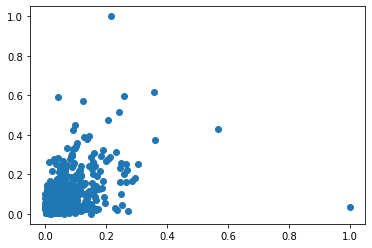

In [17]:
plot_data = dataset.copy()
plot_data['HospCt'] = (dataset['HospCt'] - np.min(dataset['HospCt']))/(np.max(dataset['HospCt']) - np.min(dataset['HospCt']))
plot_data['Deaths'] = (dataset['Deaths'] - np.min(dataset['Deaths']))/(np.max(dataset['Deaths']) - np.min(dataset['Deaths']))
fips_to_exclude1 = plot_data[plot_data['Deaths'] > .5]["FIPS"]
fips_to_exclude2 = plot_data[plot_data['HospCt'] > .5]["FIPS"]
print('Exclude these counties:')
print(fips_to_exclude1)
print(fips_to_exclude2)


plt.scatter(plot_data['Deaths'].astype(float), plot_data['HospCt'].astype(float))
np.corrcoef(plot_data['Deaths'].astype(float), plot_data['HospCt'].astype(float))

In [ ]:
#plot_data = plot_data[plot_data['FIPS'] != 36061]
#plot_data = plot_data[plot_data['FIPS'] != 6038]
#plot_data = plot_data[plot_data['FIPS'] != 17031]
#plot_data = plot_data[plot_data['FIPS'] != 48201]

dataset = dataset[dataset['FIPS'] != 36061]
dataset = dataset[dataset['FIPS'] != 51131]
dataset = dataset[dataset['FIPS'] != 22081]
dataset = dataset[dataset['FIPS'] != 1013]
dataset = dataset[dataset['FIPS'] != 20031]
dataset = dataset[dataset['FIPS'] != 45005]
dataset = dataset[dataset['FIPS'] != 20031]
dataset = dataset[dataset['FIPS'] != 51595]
dataset = dataset[dataset['FIPS'] != 28133]

array([[1.        , 0.01727248],
       [0.01727248, 1.        ]])

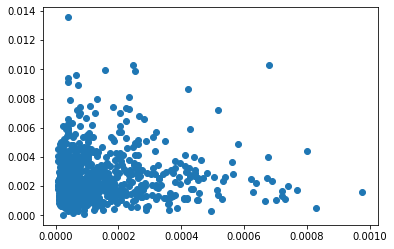

In [18]:
plt.scatter(dataset['Deaths'].astype(float), dataset['Beds'].astype(float))
np.corrcoef(dataset['Deaths'].astype(float), dataset['Beds'].astype(float))

In [ ]:
plt.scatter(dataset['Deaths'].astype(float), dataset['HospCt'].astype(float))
np.corrcoef(dataset['Deaths'].astype(float), dataset['HospCt'].astype(float))

Create the dataset that is to be fed into the classifier: For each pair of counties, take the difference in their features, and also provide an indicator variable identifying which county has more deaths

In [19]:
model_data = pd.DataFrame(columns=['Hosp_diff', 'Beds_diff', 'RUCC_diff', 'dense_diff', 'no_dip_diff', 'elderly_diff', 'unemp_diff', 'pct_pov_diff', 'pop_diff', 'death_diff', 'mob_diff', 'More_Deaths'])
model_data = model_data.apply(pd.to_numeric) 
dataset.reset_index(drop=True, inplace=True)

for fips1, fips2 in pairs:
    
    row1_df = dataset.loc[dataset["FIPS"] == fips1].reset_index(drop=True)
    row2_df = dataset.loc[dataset["FIPS"] == fips2].reset_index(drop=True)

    if row1_df.empty or row2_df.empty:
        continue
        
    for _, row1 in row1_df.iterrows():
        for _, row2 in row2_df.iterrows():
            if row1['Deaths'] != row2["Deaths"]:

                if row1['Deaths']  > row2["Deaths"]:
                    model_data = model_data.append({'Hosp_diff': float(row1['HospCt']) - float(row2['HospCt']),\
                                                        'Beds_diff': float(row1['Beds']) - float(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'area_diff':float(row1['area']) - float(row2['area']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'mob_diff' : float(row1['baseline']) - float(row2['baseline']),\
                                                        'More_Deaths':0}, ignore_index=True)   
                elif row1['Deaths']  < row2["Deaths"]:  
                    model_data = model_data.append({'Hosp_diff': float(row1['HospCt']) - float(row2['HospCt']),\
                                                        'Beds_diff': float(row1['Beds']) - float(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'area_diff':float(row1['area']) - float(row2['area']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'mob_diff' : float(row1['baseline']) - float(row2['baseline']),\
                                                        'More_Deaths':1}, ignore_index=True)  

Normalize

In [20]:
model_data = model_data.apply(pd.to_numeric) 

model_data['Hosp_diff'] = (model_data['Hosp_diff'] - np.min(model_data['Hosp_diff']))/(np.max(model_data['Hosp_diff']) - np.min(model_data['Hosp_diff']))

model_data['Beds_diff'] = (model_data['Beds_diff'] - np.min(model_data['Beds_diff']))/(np.max(model_data['Beds_diff']) - np.min(model_data['Beds_diff']))

model_data['area_diff'] = (model_data['area_diff'] - np.min(model_data['area_diff']))/(np.max(model_data['area_diff']) - np.min(model_data['area_diff']))

model_data['RUCC_diff'] = (model_data['RUCC_diff'] - np.min(model_data['RUCC_diff']))/(np.max(model_data['RUCC_diff']) - np.min(model_data['RUCC_diff']))

model_data['no_dip_diff'] = (model_data['no_dip_diff'] - np.min(model_data['no_dip_diff']))/(np.max(model_data['no_dip_diff']) - np.min(model_data['no_dip_diff']))

model_data['elderly_diff'] = (model_data['elderly_diff'] - np.min(model_data['elderly_diff']))/(np.max(model_data['elderly_diff']) - np.min(model_data['elderly_diff']))

model_data['unemp_diff'] = (model_data['unemp_diff'] - np.min(model_data['unemp_diff']))/(np.max(model_data['unemp_diff']) - np.min(model_data['unemp_diff']))

model_data['pct_pov_diff'] = (model_data['pct_pov_diff'] - np.min(model_data['pct_pov_diff']))/(np.max(model_data['pct_pov_diff']) - np.min(model_data['pct_pov_diff']))

model_data['death_diff'] = (model_data['death_diff'] - np.min(model_data['death_diff']))/(np.max(model_data['death_diff']) - np.min(model_data['death_diff']))

model_data['mob_diff'] = (model_data['mob_diff'] - np.min(model_data['mob_diff']))/(np.max(model_data['mob_diff']) - np.min(model_data['mob_diff']))

In [21]:
print(len(model_data))
model_data.head()

1128


,Hosp_diff,Beds_diff,RUCC_diff,dense_diff,no_dip_diff,elderly_diff,unemp_diff,pct_pov_diff,pop_diff,death_diff,mob_diff,More_Deaths,area_diff
0,0.408894,0.536854,0.545455,NaN,0.295983,0.568374,0.465201,0.435337,98101.0,0.403012,0.549937,1.0,0.737576
1,0.543015,0.625314,0.454545,NaN,0.486258,0.565164,0.432234,0.530055,-76139.0,0.474788,0.491568,0.0,0.707263
2,0.356465,0.260645,0.545455,NaN,0.323467,0.673811,0.369963,0.222222,-26464.0,0.435050,0.734451,1.0,0.760738
3,0.482173,0.927145,0.545455,NaN,0.528541,0.640092,0.501832,0.857923,83183.0,0.442186,0.481473,1.0,0.744304
4,0.636178,0.531078,0.727273,NaN,0.520085,0.613202,0.498168,0.497268,-300274.0,0.301940,0.669324,1.0,0.747658


In [22]:
model_data = model_data.sample(frac=1, random_state=9)
training_set = model_data.head(900)
test_set = model_data.tail(228)

array([[1.       , 0.4275236],
       [0.4275236, 1.       ]])

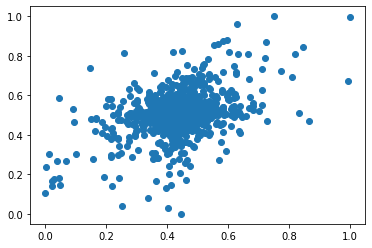

In [23]:
import matplotlib.pyplot as plt

plot_data = pd.concat([training_set, test_set])
plt.scatter(plot_data['death_diff'], plot_data['Hosp_diff'])
np.corrcoef(plot_data['death_diff'], plot_data['Hosp_diff'])

array([[ 1.        , -0.11212205],
       [-0.11212205,  1.        ]])

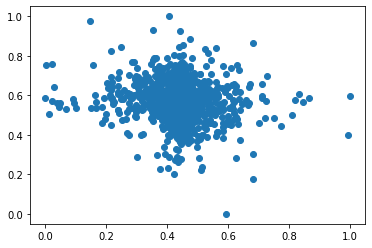

In [24]:
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff'])

[[1.         0.05565374]
 [0.05565374 1.        ]]


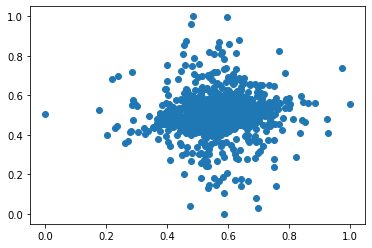

In [25]:
print(np.corrcoef(plot_data['Beds_diff'], plot_data['Hosp_diff']))
plt.scatter(plot_data['Beds_diff'], plot_data['Hosp_diff'])

Write out dataset for R processing

In [26]:
model_data.to_csv('./3_deaths_20_days.tsv', sep='\t')

In [27]:
print(len(training_set))
print(len(test_set))
print(sum(training_set['More_Deaths'])/len(training_set))
print(sum(test_set['More_Deaths'])/len(test_set))

900
228
0.5144444444444445
0.5131578947368421


In [28]:
test_features(['Hosp_diff'])
test_features(['Beds_diff'])
test_features(['area_diff'])
test_features(['RUCC_diff'])
test_features(['mob_diff'])
test_features(['mob_diff', 'Hosp_diff'])
test_features(['RUCC_diff', 'area_diff', 'mob_diff', 'Hosp_diff'])

Features: ['Hosp_diff']
Test Ratio: 0.5131578947368421
Score: 0.6228070175438597
Coefficients: [[-3.14686405]]

Features: ['Beds_diff']
Test Ratio: 0.5131578947368421
Score: 0.543859649122807
Coefficients: [[0.89544674]]

Features: ['area_diff']
Test Ratio: 0.5131578947368421
Score: 0.5043859649122807
Coefficients: [[0.21468367]]

Features: ['RUCC_diff']
Test Ratio: 0.5131578947368421
Score: 0.5394736842105263
Coefficients: [[-2.6867828]]

Features: ['mob_diff']
Test Ratio: 0.5131578947368421
Score: 0.5833333333333334
Coefficients: [[-2.20883517]]

Features: ['mob_diff', 'Hosp_diff']
Test Ratio: 0.5131578947368421
Score: 0.6271929824561403
Coefficients: [[-1.57635661 -2.70890528]]

Features: ['RUCC_diff', 'area_diff', 'mob_diff', 'Hosp_diff']
Test Ratio: 0.5131578947368421
Score: 0.6271929824561403
Coefficients: [[-2.14358706  1.22149446 -1.62014022 -1.64826452]]



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[[ 1.         -0.10488637]
 [-0.10488637  1.        ]]
[[1.         0.42168209]
 [0.42168209 1.        ]]
[[1.         0.07850555]
 [0.07850555 1.        ]]


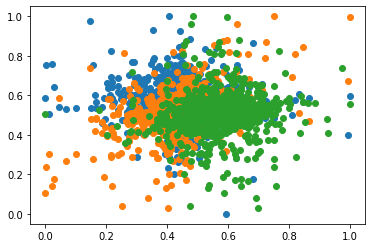

In [29]:
import matplotlib.pyplot as plt

plot_data = training_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

plot_data = training_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Hosp_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Hosp_diff']))

plot_data = training_set.copy()
plt.scatter(plot_data['Beds_diff'], plot_data['Hosp_diff'])
print(np.corrcoef(plot_data['Beds_diff'], plot_data['Hosp_diff']))